In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from collections import defaultdict
import re
import glob
import os
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, label_order, \
                        figure_path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def genome_rna():
    def change_type(x):
        if x == 'lncRNA':
            return 'Other ncRNA'
        else:
            return x
        
    return pd.read_table('/stor/work/Lambowitz/ref/hg19/new_genes/theoretical/theoretical_base_count.tsv') \
        .assign(grouped_type = lambda d: d.rna_type.map(lambda x: x.strip('b').strip("'"))) \
        .assign(grouped_type = lambda d: d.grouped_type.map(change_type))\
        .query('grouped_type != "other"')\
        .assign(base_fraction = lambda d: d.base_fraction / d.base_fraction.sum() * 100)\
        .pipe(pd.pivot_table, columns = 'grouped_type', values='base_fraction', aggfunc=np.sum) \
        .assign(treatment = 'Genome')\
        .set_index('treatment')

## plot count function

In [13]:
def plot_count(ax, feature_only=True):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    filter_feature = 'No features' if feature_only else ''
    
    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF|sim')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .query('grouped_type != "%s"' %filter_feature)\
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre|sim')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .reindex(index=label_order)\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation = 70, ha = 'right',
                      rotation_mode="anchor")
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (0.9,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

# insert size

In [14]:
def plot_insert(ax):
    insert_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/fragment_sizes'
    data_files = glob.glob(insert_path + '/*.tsv')
    df = {os.path.basename(data_file):pd.read_table(data_file) for data_file in data_files}
    df = pd.concat([val.assign(label = key) for key, val in df.items()]) \
        .assign(label = lambda d: d.label.str.replace('.tsv','').str.capitalize())\
        .assign(label = lambda d: np.where(d.label == 'Polya','PolyA-selected', d.label))\
        .sort_values('isize') \
        .query('isize < 400') \
        .assign(size_fraction = lambda d: d.groupby('label')['size_count'].transform(lambda x: 100* x/ x.sum()))\
        .pipe(lambda d: d[d.label.str.contains('Alk|Un|[Ee]xo|All')]) \
        .assign(label = lambda d: d.label.map(label_sample)) 
    
    for lab, lab_df in df.groupby('label'):
        ax.plot(lab_df['isize'], 
                 lab_df['size_fraction'], 
                 linewidth=3,
                 label = lab,
                 color = label_ce.encoder[lab])
        
    ax.legend(title= ' ', 
             fontsize = 15, 
             frameon=False, 
             bbox_to_anchor = (0.6,0.8))
    ax.set_xlabel('Read span (nt)')
    ax.set_ylabel('Read pairs (%)')
    
    
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_x(label.get_position()[0] + 1)

In [15]:
metric_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam/filtered_bam'
metrics = glob.glob(metric_path + '/*.filtered.RNA_Metrics')

def read_metric(metric):
    return pd.read_table(metric, skiprows=6, nrows=1)\
        .pipe(pd.melt) \
        .pipe(lambda d: d[d.variable.str.contains('TRANSCRIPT_STRAND_')])\
        .pipe(lambda d: d[d.variable.str.contains('PCT')]) 

def plot_strand(ax):
    strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
    strand_df = pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('[uU]nt|unf|[Aa]lka|[eE]xo|sim')])\
        .assign(samplename = lambda d: d.samplename.map(label_sample))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense','Antisense'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, ax = ax, width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Protein-coding bases (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (.9,1), fontsize = 15,
             frameon=False)
    
    
def plot_coding_bases(ax):
    RNA_base_from_picard(metrics) \
        .assign(var_count = lambda d: d.var_count*100)\
        .pipe(lambda d: d[d.samplename.str.contains('[eE]xo|[uU]nt|unf|[Aa]lka|sim')])\
        .assign(samplename = lambda d: d.samplename.str.split('.',expand=True).iloc[:,0].map(label_sample))\
        .assign(variable = lambda d: d.variable.str.replace('Utr','UTR'))\
        .assign(variable = lambda d: d.variable.str.replace(' bases',''))\
        .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, width = 0.8, color = simpsons_palette(), ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.set_ylabel('Protein-coding bases (%)')
    ax.set_xlabel('')
    ax.legend(title = '', bbox_to_anchor = (1,1))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.9,1), 
              fontsize = 15, frameon=False)

In [16]:
    RNA_base_from_picard(metrics) \
        .assign(var_count = lambda d: d.var_count*100)\
        .pipe(lambda d: d[d.samplename.str.contains('[eE]xo|[uU]nt|unf|[Aa]lka|genome')])\
        .assign(samplename = lambda d: d.samplename.str.split('.',expand=True).iloc[:,0].map(label_sample))\
        .assign(variable = lambda d: d.variable.str.replace('Utr','UTR'))\
        .assign(variable = lambda d: d.variable.str.replace(' bases',''))\
        .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')\
        .reindex(index=label_order)

variable,Coding,Intergenic,Intronic,UTR
samplename,,,,
Untreated,3.9365,0.0629,90.7136,5.2870
NaOH,4.0979,0.0687,90.2830,5.5504
DNase I,18.3859,0.1769,67.9275,13.5096
DNase I + Exo I,20.5946,0.1569,64.9070,14.3416
WGS-sim,2.7647,0.0557,92.2708,4.9088


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


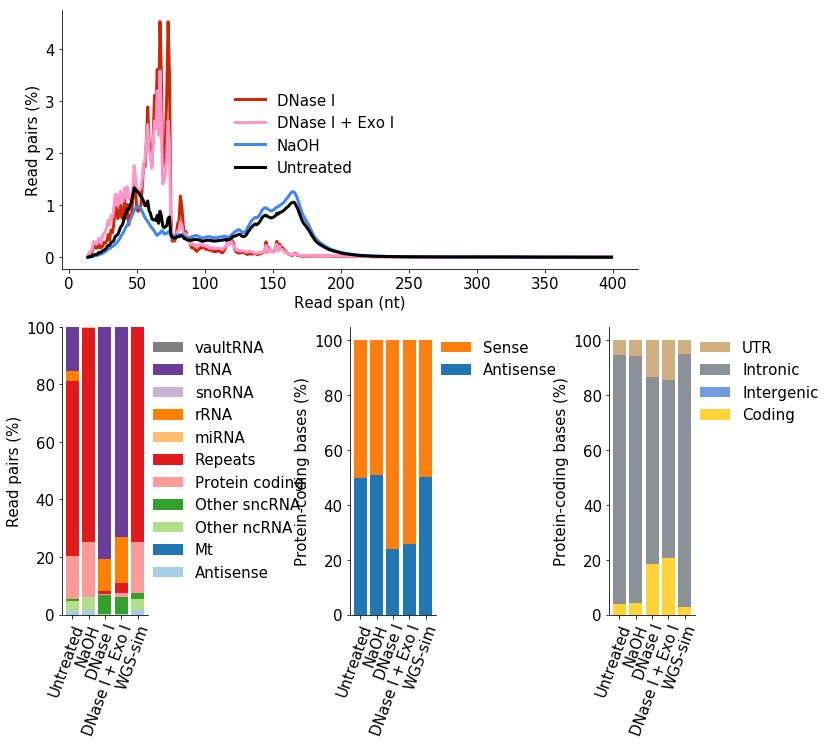

In [17]:
fig = plt.figure(figsize = (8,8))
ax_insert = fig.add_axes([0,0.6,1,0.45])
plot_insert(ax_insert)



# lower
ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
ax_strand = fig.add_axes([0.5,0,0.15,0.5])
ax_coding = fig.add_axes([0.95,0,0.15,0.5])


#plot_count(ax_frag_dist, feature_only=False)
plot_count(ax_frag_dist, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


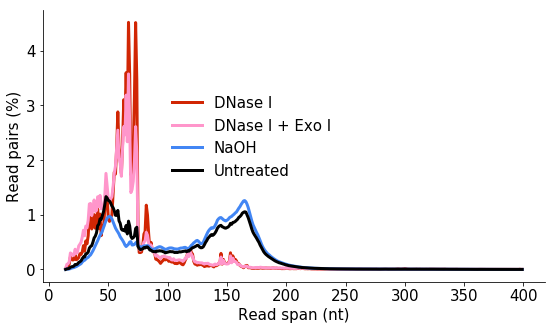

In [18]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
plot_insert(ax_insert)
sns.despine()
fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


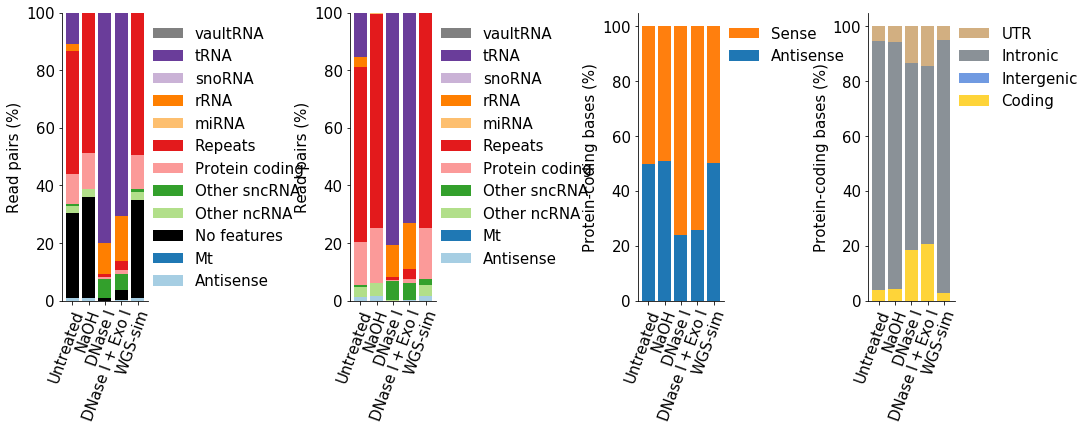

In [19]:
fig = plt.figure(figsize = (8,8))
ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
ax_strand = fig.add_axes([1,0,0.15,0.5])
ax_coding = fig.add_axes([1.4,0,0.15,0.5])

plot_count(ax_frag_dist, feature_only=False)
plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.1,0.86,"Pearson's $\\rho$")

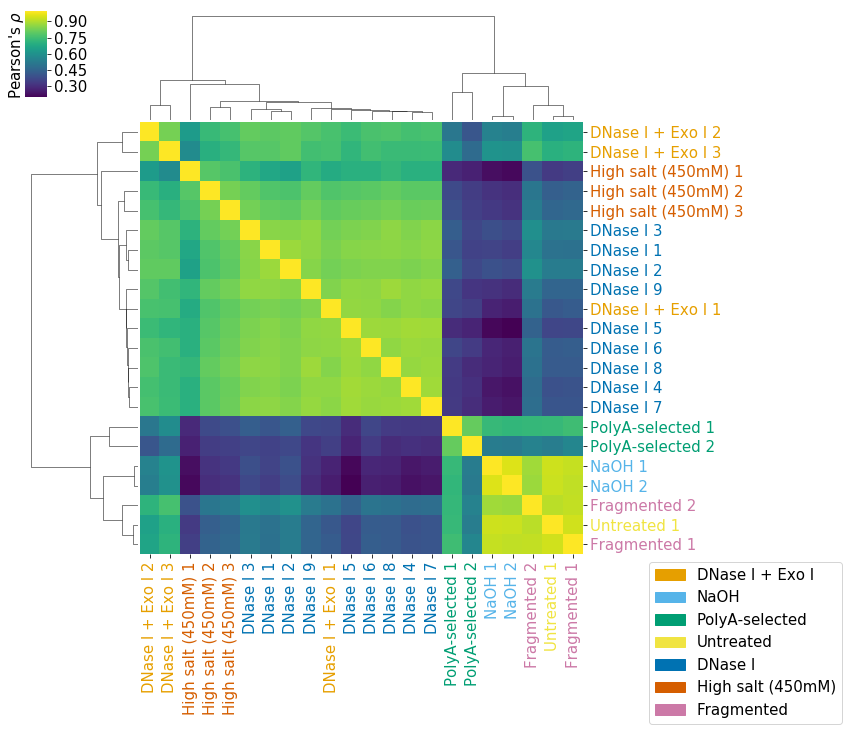

In [21]:
from collections import defaultdict
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
cor_df = np.log(dedup_df\
                    .filter(regex = 'Qcf|QCF')\
                    .filter(regex="dedup:sense") \
                    .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [ ]:
strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('unf|[Aa]lka')])\
        .assign(samplename = lambda d: np.where(d.samplename.str.contains('[aA]lka'),'Alkaline\nhydrolysis','DNase\ntreated'))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense strand','Antisense-strand'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')

In [ ]:
RNA_base_from_picard(metrics) \
    .pipe(lambda d: d[d.samplename.str.contains('unfr|alka')]) \
    .assign(var_count = lambda d: d.var_count*100)\
    .assign(samplename = lambda d: np.where(d.samplename.str.contains('[Aa]lk'), 'Alkaline hydrolysis', 'DNase-treated'))\
    .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')

In [ ]:
def plot_count_with_genome(ax):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .pipe(lambda d: pd.concat([d, genome_rna()], sort=True))\
        .reindex(index=np.append('Genome', label_order))\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (1,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_count_with_genome(ax)

In [ ]:
np.append('Genome', label_order)

In [ ]:
countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
countplot_df

In [ ]:
dedup_df \
        .filter(regex = 'id|type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .query('grouped_type == "rRNA"')\
        .groupby('gene_id')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup|gene_id')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['gene_id','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'gene_id',
             values = 'value')

In [ ]:
28.2 + 62.98

In [ ]:
6.075118 + 2.731050

In [ ]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


countplot_df = dedup_df \
        .filter(regex = 'id|type|Q[cC][fF][0-9]+')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('id|type|dedup')]]) \
        .pipe(lambda d: d[d.grouped_type.str.contains('sno|tRN|vault|sncRNA|mi|snR')]) \
        .assign(sum_count = lambda d: d.iloc[:,3:].sum(axis=1)) \
        .groupby(['grouped_type'], as_index=False)\
        .apply(lambda d: d.nlargest(10, 'sum_count'))\
        .reset_index()
#        .pipe(pd.melt, id_vars = ['grouped_type']) \
#        .assign(treatment = lambda d: d.variable.map(label_sample)) \
#        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])
countplot_df.head()

In [ ]:
'|'.join(countplot_df.query('grouped_type == "miRNA"').gene_id.tolist())

In [ ]:
dedup_df.grouped_type.unique()